In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# preprocess

In [2]:
import numpy as np

with open("/content/drive/Shareddrives/CV_Action_Recognition_Project/Dataset/UCF/npy_files/" + "raw_crops_rgb_and_flow.npy", 'rb') as f:
    data_one_crop = np.load(f, allow_pickle=True)
    data_two_crop = np.load(f, allow_pickle=True)
    flow_one_crop = np.load(f, allow_pickle=True)
    flow_two_crop = np.load(f, allow_pickle=True)
    label = np.load(f, allow_pickle=True)


data_one_crop = data_one_crop / 255
data_two_crop = data_two_crop / 255
flow_one_crop = flow_one_crop / 255
flow_two_crop = flow_two_crop / 255

In [3]:
labels = label

## just run

In [8]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import gc
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

In [10]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)


def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])



class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos



## models

In [6]:
def get_one_stream_model():
  HEIGHT = 224
  WIDTH = 224
  input_shape = (None, 8, HEIGHT, WIDTH, 3)
  input = layers.Input(shape=(input_shape[1:]))
  x = input

  x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

  # Block 1
  x = add_residual_block(x, 16, (3, 3, 3))
  x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

  # Block 2
  x = add_residual_block(x, 32, (3, 3, 3))
  x = ResizeVideo(HEIGHT // 32, WIDTH // 32)(x)

  # Block 3
  x = add_residual_block(x, 64, (3, 3, 3))

  x = layers.GlobalAveragePooling3D()(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.4)(x)
  x = layers.Dense(128)(x)
  x = layers.Dense(13)(x)

  model = keras.Model(input, x)
  return model

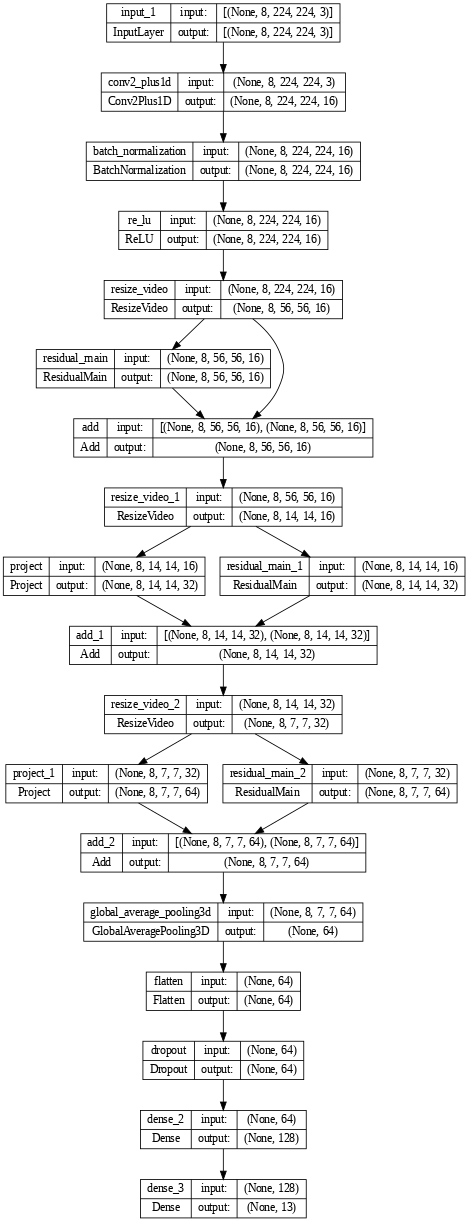

In [7]:
model = get_one_stream_model()
model.build(data_one_crop[0])
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 conv2_plus1d (Conv2Plus1D)     (None, 8, 224, 224,  3152        ['input_1[0][0]']                
                                 16)                                                              
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 224, 224,  64         ['conv2_plus1d[0][0]']           
 alization)                      16)                                                          

In [11]:
def get_one_stream_model_6ch():
  HEIGHT = 224
  WIDTH = 224
  input_shape = (None, 8, HEIGHT, WIDTH, 6)
  input = layers.Input(shape=(input_shape[1:]))
  x = input

  x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

  # Block 1
  x = add_residual_block(x, 16, (3, 3, 3))
  x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

  # Block 2
  x = add_residual_block(x, 32, (3, 3, 3))
  x = ResizeVideo(HEIGHT // 32, WIDTH // 32)(x)

  # Block 3
  x = add_residual_block(x, 64, (3, 3, 3))

  x = layers.GlobalAveragePooling3D()(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(128)(x)
  x = layers.Dense(13)(x)

  model = keras.Model(input, x)
  return model

In [10]:
flow_one_crop[0].shape

(8, 224, 224, 3)

In [11]:
np.concatenate([data_one_crop[0], flow_one_crop[0]], axis = 3).shape

(8, 224, 224, 6)

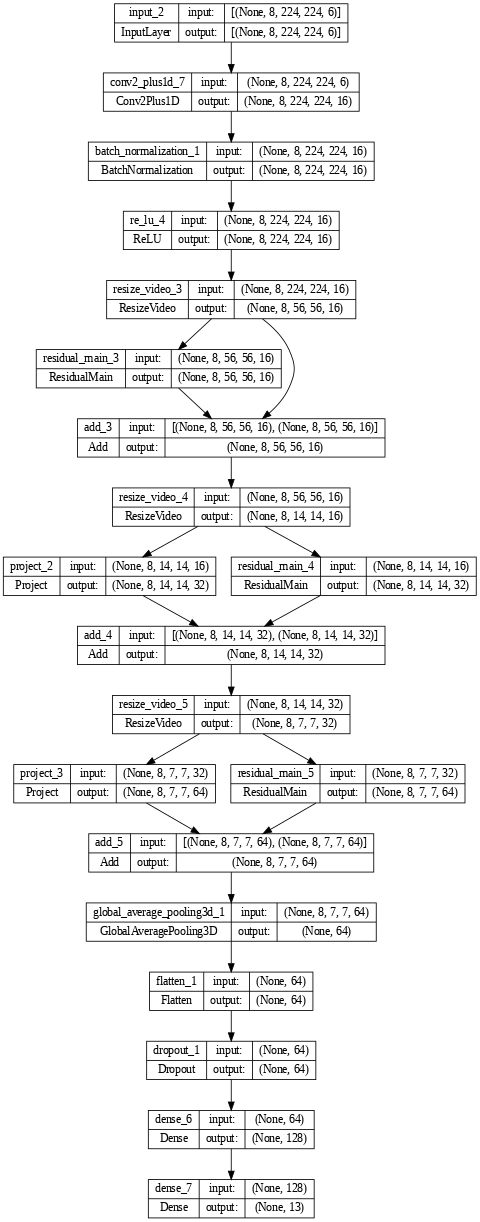

In [12]:
model = get_one_stream_model_6ch()
model.build(np.concatenate([data_one_crop[0], flow_one_crop[0]], axis = 3))
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)


In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 224, 224  0           []                               
                                , 6)]                                                             
                                                                                                  
 conv2_plus1d_7 (Conv2Plus1D)   (None, 8, 224, 224,  5504        ['input_2[0][0]']                
                                 16)                                                              
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 8, 224, 224,  64         ['conv2_plus1d_7[0][0]']         
 rmalization)                    16)                                                        

In [8]:
def get_two_stream_model():
  HEIGHT = 224
  WIDTH = 224
  input_shape = (None, 2, 8, HEIGHT, WIDTH, 3)
  input1 = layers.Input(shape=(input_shape[2:]))
  input2 = layers.Input(shape=(input_shape[2:]))
  x = input1
  x2 = input2

  x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

  # Block 1
  x = add_residual_block(x, 16, (3, 3, 3))
  x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

  # Block 2
  x = add_residual_block(x, 32, (3, 3, 3))
  x = ResizeVideo(HEIGHT // 32, WIDTH // 32)(x)

  # Block 3
  x = add_residual_block(x, 64, (3, 3, 3))

  x = layers.GlobalAveragePooling3D()(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.4)(x)

  x2 = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)
  x2 = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x2)

  # Block 1
  x2 = add_residual_block(x2, 16, (3, 3, 3))
  x2 = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x2)

  # Block 2
  x2 = add_residual_block(x2, 32, (3, 3, 3))
  x2 = ResizeVideo(HEIGHT // 32, WIDTH // 32)(x2)

  # Block 3
  x2 = add_residual_block(x2, 64, (3, 3, 3))

  x2 = layers.GlobalAveragePooling3D()(x2)
  x2 = layers.Flatten()(x2)
  x2 = layers.Dropout(0.4)(x2)


  merged = keras.layers.Concatenate(axis=1)([x, x2])

  merged = layers.Dense(128)(merged)
  output = layers.Dense(13)(merged)

  model = keras.Model(inputs=[input1, input2], outputs = output)
  return model

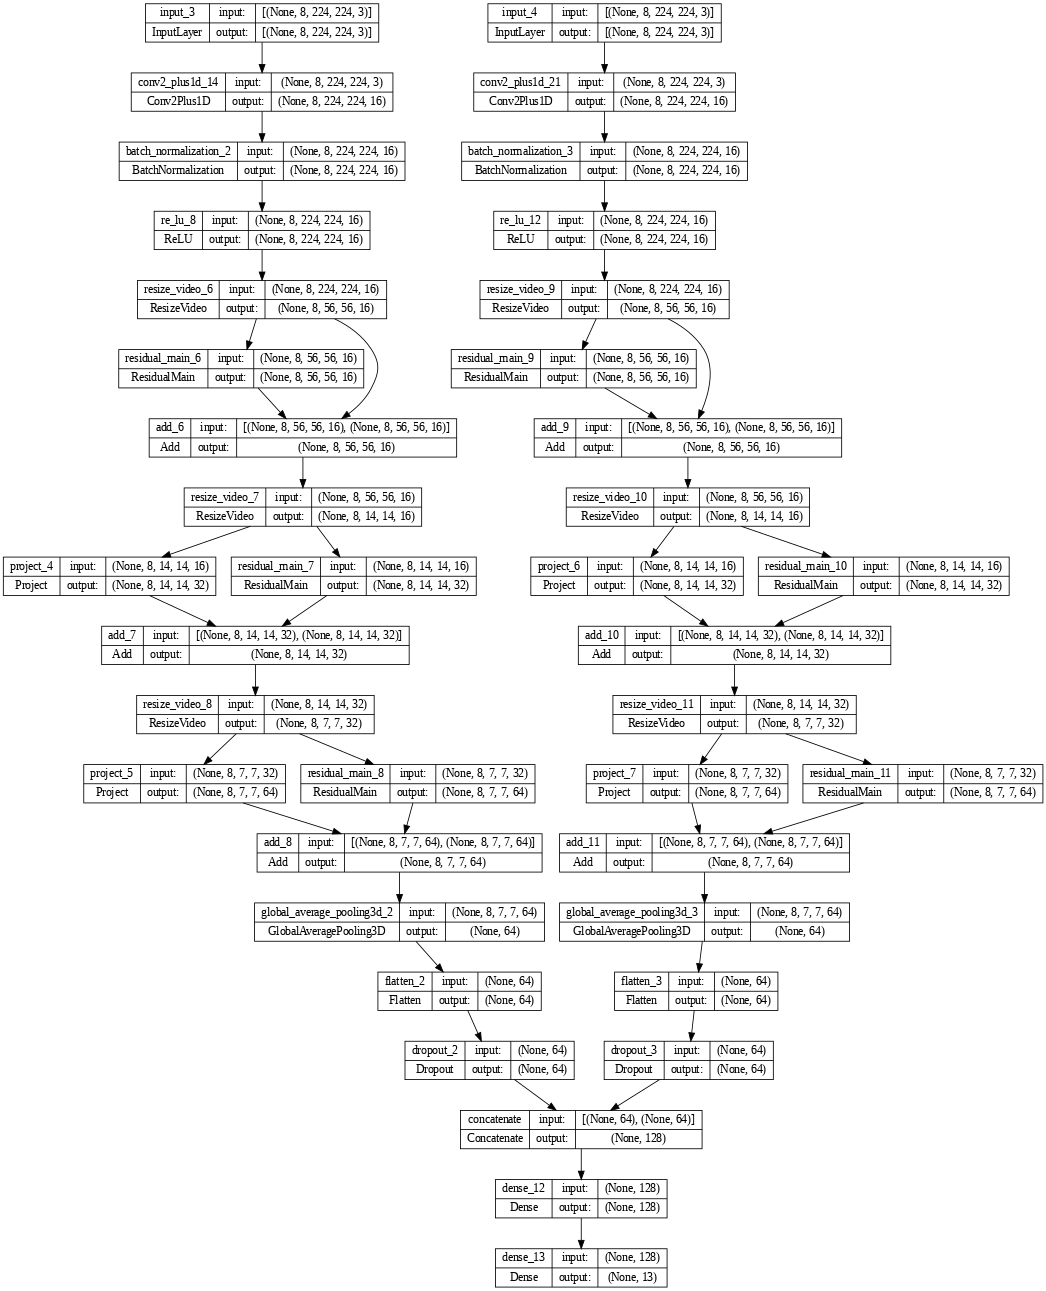

In [15]:
model = get_two_stream_model()
model.build(data_two_crop[0])
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [16]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 input_4 (InputLayer)           [(None, 8, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 conv2_plus1d_14 (Conv2Plus1D)  (None, 8, 224, 224,  3152        ['input_3[0][0]']                
                                 16)                                                        

In [17]:
def get_two_stream_model_6ch():
  HEIGHT = 224
  WIDTH = 224
  input_shape = (None, 2, 8, HEIGHT, WIDTH, 6)
  input1 = layers.Input(shape=(input_shape[2:]))
  input2 = layers.Input(shape=(input_shape[2:]))
  x = input1
  x2 = input2

  x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

  # Block 1
  x = add_residual_block(x, 16, (3, 3, 3))
  x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

  # Block 2
  x = add_residual_block(x, 32, (3, 3, 3))
  x = ResizeVideo(HEIGHT // 32, WIDTH // 32)(x)

  # Block 3
  x = add_residual_block(x, 64, (3, 3, 3))

  x = layers.GlobalAveragePooling3D()(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.4)(x)

  x2 = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)
  x2 = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x2)

  # Block 1
  x2 = add_residual_block(x2, 16, (3, 3, 3))
  x2 = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x2)

  # Block 2
  x2 = add_residual_block(x2, 32, (3, 3, 3))
  x2 = ResizeVideo(HEIGHT // 32, WIDTH // 32)(x2)

  # Block 3
  x2 = add_residual_block(x2, 64, (3, 3, 3))

  x2 = layers.GlobalAveragePooling3D()(x2)
  x2 = layers.Flatten()(x2)
  x2 = layers.Dropout(0.4)(x2)


  merged = keras.layers.Concatenate(axis=1)([x, x2])

  merged = layers.Dense(128)(merged)
  output = layers.Dense(13)(merged)

  model = keras.Model(inputs=[input1, input2], outputs = output)
  return model

In [18]:
data_two_crop.shape

(140, 8, 2, 224, 224, 3)

In [19]:
fusion_u = np.concatenate([data_two_crop[:, :, 0][0], flow_two_crop[:, :, 0][0]], axis = 3)
fusion_l = np.concatenate([data_two_crop[:, :, 1][0], flow_two_crop[:, :, 1][0]], axis = 3)


In [20]:
model = get_two_stream_model_6ch()
model.build([fusion_u, fusion_l])
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 8, 224, 224  0           []                               
                                , 6)]                                                             
                                                                                                  
 input_6 (InputLayer)           [(None, 8, 224, 224  0           []                               
                                , 6)]                                                             
                                                                                                  
 conv2_plus1d_28 (Conv2Plus1D)  (None, 8, 224, 224,  5504        ['input_5[0][0]']                
                                 16)                                                        

In [7]:
def get_four_stream_model():
  HEIGHT = 224
  WIDTH = 224
  input_shape = (None, 4, 8, HEIGHT, WIDTH, 3)
  input1 = layers.Input(shape=(input_shape[2:]))
  input2 = layers.Input(shape=(input_shape[2:]))
  input3 = layers.Input(shape=(input_shape[2:]))
  input4 = layers.Input(shape=(input_shape[2:]))
  
  x = input1
  x2 = input2
  x3 = input3
  x4 = input4


  x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

  # Block 1
  x = add_residual_block(x, 16, (3, 3, 3))
  x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

  # Block 2
  x = add_residual_block(x, 32, (3, 3, 3))
  x = ResizeVideo(HEIGHT // 32, WIDTH // 32)(x)

  # Block 3
  x = add_residual_block(x, 64, (3, 3, 3))

  x = layers.GlobalAveragePooling3D()(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.4)(x)

  x2 = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)
  x2 = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x2)

  # Block 1
  x2 = add_residual_block(x2, 16, (3, 3, 3))
  x2 = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x2)

  # Block 2
  x2 = add_residual_block(x2, 32, (3, 3, 3))
  x2 = ResizeVideo(HEIGHT // 32, WIDTH // 32)(x2)

  # Block 3
  x2 = add_residual_block(x2, 64, (3, 3, 3))

  x2 = layers.GlobalAveragePooling3D()(x2)
  x2 = layers.Flatten()(x2)
  x2 = layers.Dropout(0.4)(x2)

  merged_u = keras.layers.Concatenate(axis=1)([x, x2])
  merged_u = layers.Dense(128)(merged_u)

  x3 = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x3)
  x3 = layers.BatchNormalization()(x3)
  x3 = layers.ReLU()(x3)
  x3 = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x3)

  # Block 1
  x3 = add_residual_block(x3, 16, (3, 3, 3))
  x3 = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x3)

  # Block 2
  x3 = add_residual_block(x3, 32, (3, 3, 3))
  x3 = ResizeVideo(HEIGHT // 32, WIDTH // 32)(x3)

  # Block 3
  x3 = add_residual_block(x3, 64, (3, 3, 3))

  x3 = layers.GlobalAveragePooling3D()(x3)
  x3 = layers.Flatten()(x3)
  x3 = layers.Dropout(0.4)(x3)

  x4 = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x4)
  x4 = layers.BatchNormalization()(x4)
  x4 = layers.ReLU()(x4)
  x4 = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x4)

  # Block 1
  x4 = add_residual_block(x4, 16, (3, 3, 3))
  x4 = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x4)

  # Block 2
  x4 = add_residual_block(x4, 32, (3, 3, 3))
  x4 = ResizeVideo(HEIGHT // 32, WIDTH // 32)(x4)

  # Block 3
  x4 = add_residual_block(x4, 64, (3, 3, 3))

  x4 = layers.GlobalAveragePooling3D()(x4)
  x4 = layers.Flatten()(x4)
  x4 = layers.Dropout(0.4)(x4)

  merged_l = keras.layers.Concatenate(axis=1)([x3, x4])
  merged_l = layers.Dense(128)(merged_l)

  merged = keras.layers.Concatenate(axis=1)([merged_u, merged_l])

  merged = layers.Dense(128)(merged)
  merged = layers.Dropout(0.4)(merged)
  output = layers.Dense(13)(merged)

  model = keras.Model(inputs=[input1, input2, input3, input4], outputs = output)
  return model

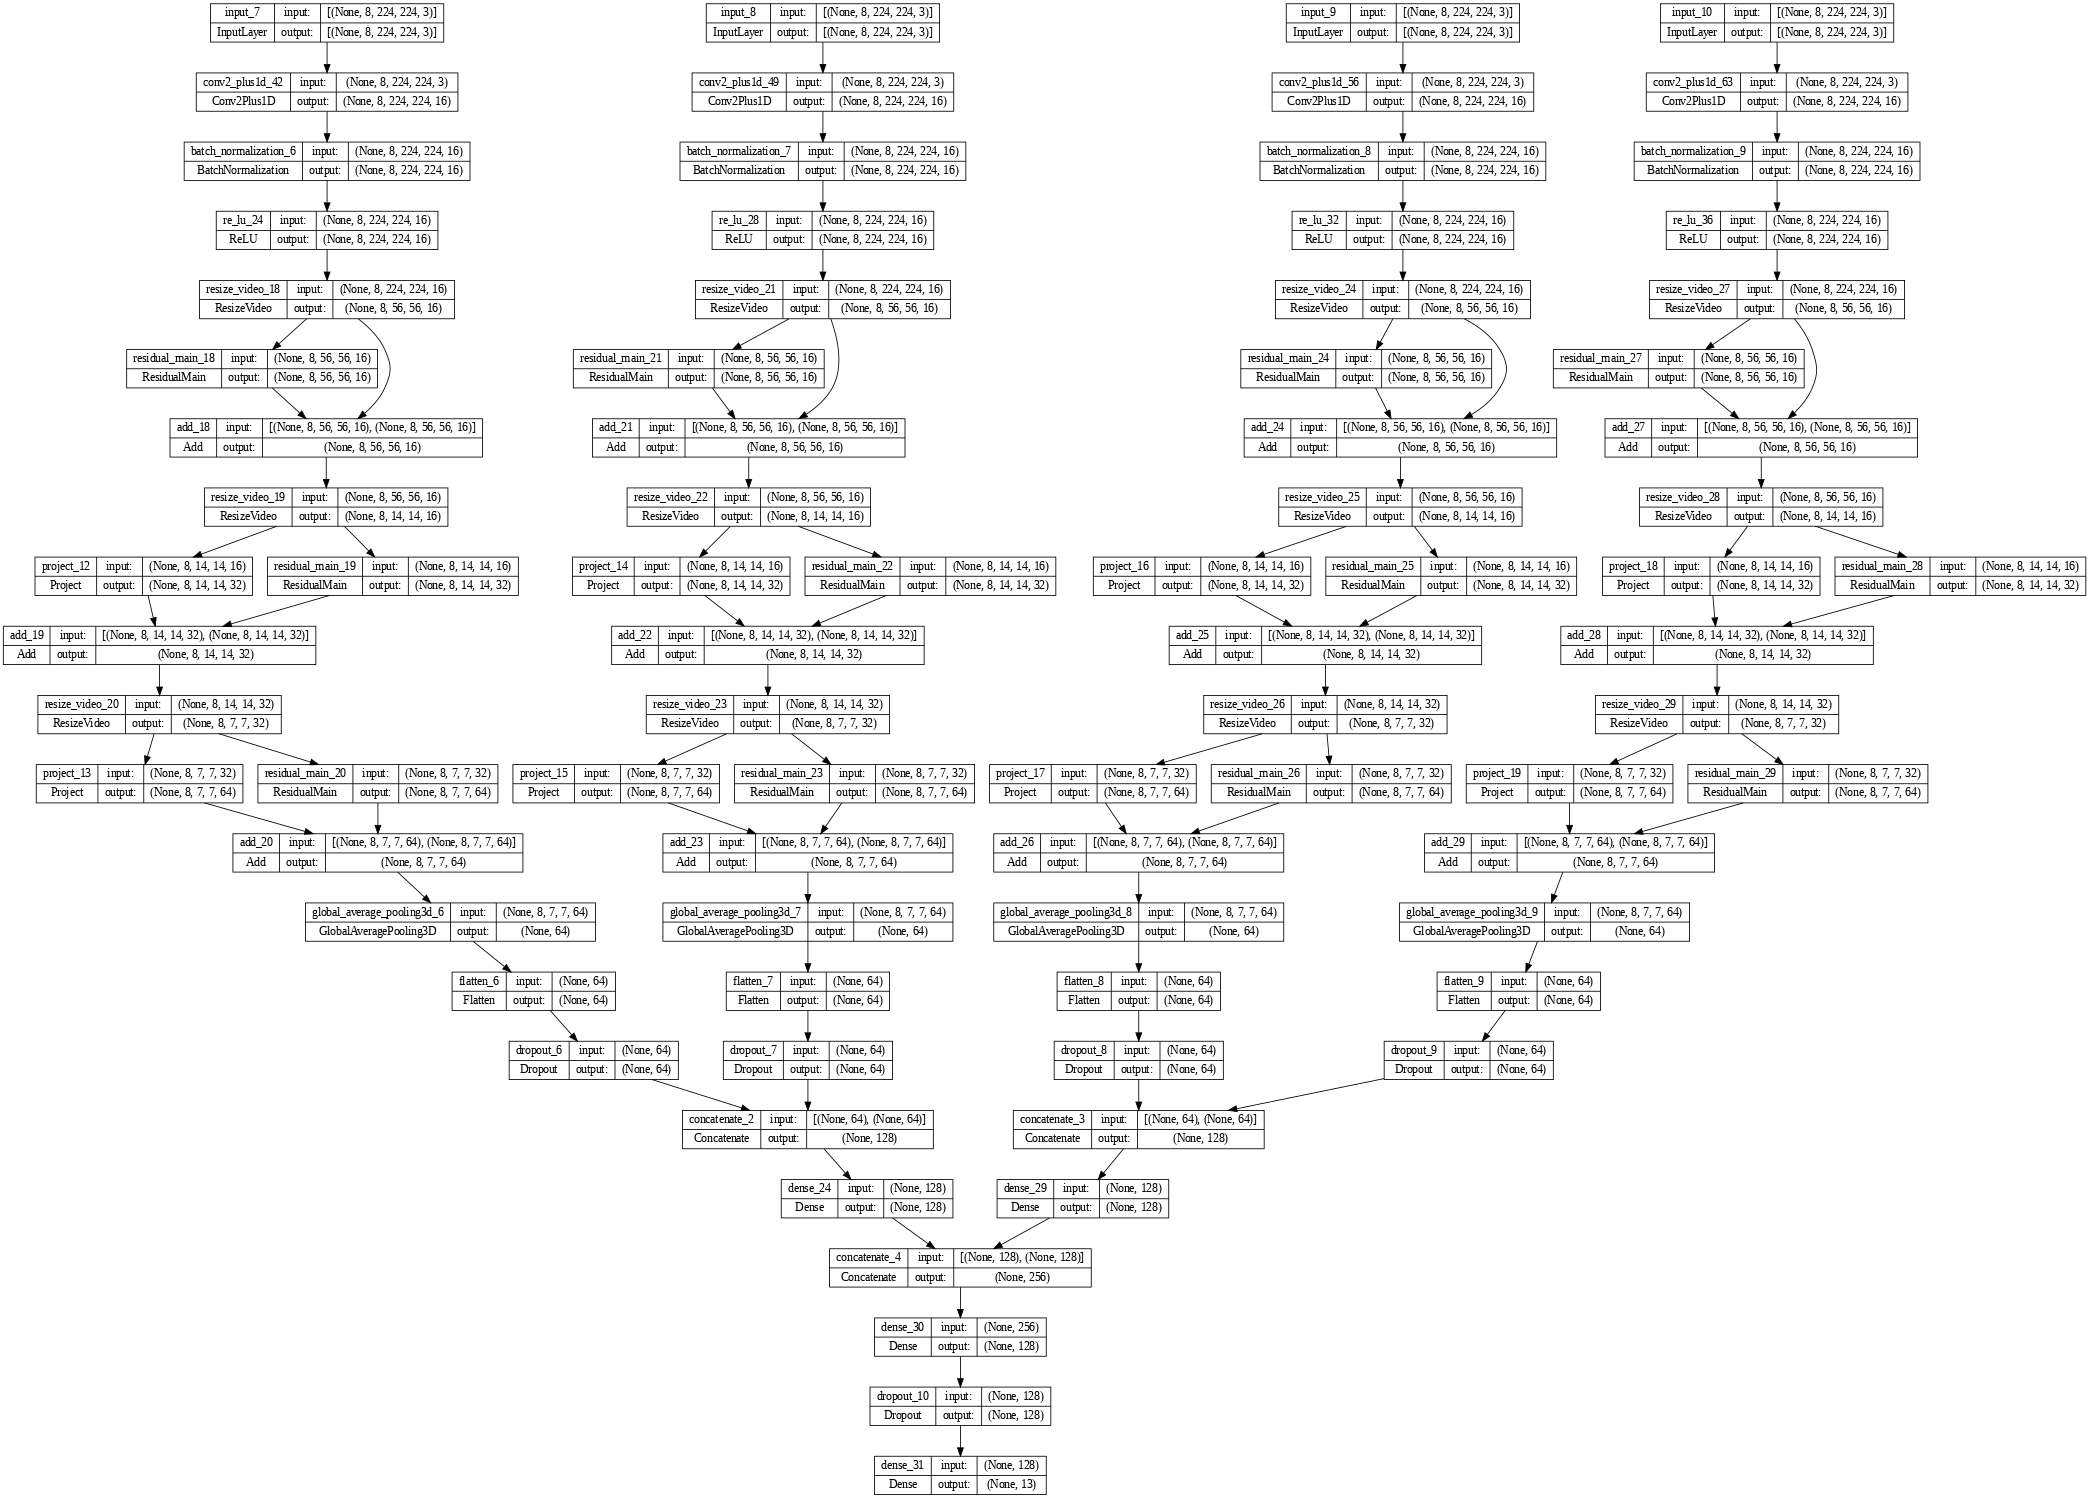

In [22]:
model = get_four_stream_model()

model.build([data_two_crop[:, :, 0][0], flow_two_crop[:, :, 0][0], data_two_crop[:, :, 1][0], flow_two_crop[:, :, 1][0]])
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)


In [23]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 8, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 input_8 (InputLayer)           [(None, 8, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 input_9 (InputLayer)           [(None, 8, 224, 224  0           []                               
                                , 3)]                                                       

# 1 crop rgb

Epoch 1/150
4/4 [==============================] - 24s 2s/step - loss: 3.2755 - accuracy: 0.1250 - val_loss: 2.7868 - val_accuracy: 0.1071
Epoch 2/150
4/4 [==============================] - 3s 781ms/step - loss: 2.9376 - accuracy: 0.0893 - val_loss: 2.6554 - val_accuracy: 0.1071
Epoch 3/150
4/4 [==============================] - 3s 731ms/step - loss: 2.4923 - accuracy: 0.1429 - val_loss: 2.5287 - val_accuracy: 0.0714
Epoch 4/150
4/4 [==============================] - 3s 874ms/step - loss: 2.4643 - accuracy: 0.1518 - val_loss: 2.4201 - val_accuracy: 0.2143
Epoch 5/150
4/4 [==============================] - 3s 746ms/step - loss: 2.3923 - accuracy: 0.2232 - val_loss: 2.4216 - val_accuracy: 0.1786
Epoch 6/150
4/4 [==============================] - 3s 738ms/step - loss: 2.2630 - accuracy: 0.2232 - val_loss: 2.4064 - val_accuracy: 0.1786
Epoch 7/150
4/4 [==============================] - 3s 750ms/step - loss: 2.2009 - accuracy: 0.2500 - val_loss: 2.3097 - val_accuracy: 0.2500
Epoch 8/150
4/4

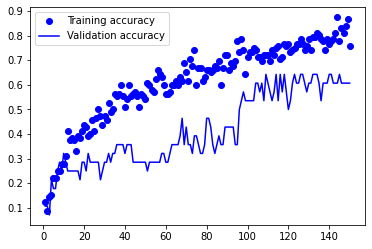

Test accuracy: 60.71%


3675

In [ ]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

test_accuracy = []
train_accuracy = []
val_accuracy = []
plotIsNeeded = True


for train_index, test_index in kf.split(data_one_crop, labels):

  data_train, data_test = data_one_crop[train_index], data_one_crop[test_index]
  label_train, label_test = labels[train_index], labels[test_index]

  model = get_one_stream_model()
  #model.build(data_train[0])

  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])
  
  history = model.fit(data_train, label_train,
                    epochs = 150, 
                    validation_data = (data_test, label_test))
 
  acc = history.history['accuracy']
  epochs = range(1, len(acc) + 1)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  if plotIsNeeded:
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()
    plotIsNeeded = False
  
  train_accuracy.append(history.history['accuracy'][-1])
  val_accuracy.append(history.history['val_accuracy'][-1])
  
  print(f"Test accuracy: {round(history.history['val_accuracy'][-1] * 100, 2)}%")
  break

del model
del data_train
del data_test
gc.collect()

# Upper crop rbg

(28, 8, 2, 224, 224, 3)
(28, 8, 224, 224, 3)
Epoch 1/150
4/4 [==============================] - 7s 1s/step - loss: 3.2592 - accuracy: 0.0625 - val_loss: 2.6835 - val_accuracy: 0.0714
Epoch 2/150
4/4 [==============================] - 3s 758ms/step - loss: 2.8854 - accuracy: 0.1250 - val_loss: 2.6892 - val_accuracy: 0.0714
Epoch 3/150
4/4 [==============================] - 3s 750ms/step - loss: 2.6708 - accuracy: 0.1250 - val_loss: 2.6480 - val_accuracy: 0.0714
Epoch 4/150
4/4 [==============================] - 3s 752ms/step - loss: 2.6873 - accuracy: 0.1161 - val_loss: 2.5644 - val_accuracy: 0.0714
Epoch 5/150
4/4 [==============================] - 3s 744ms/step - loss: 2.5339 - accuracy: 0.1429 - val_loss: 2.5526 - val_accuracy: 0.1071
Epoch 6/150
4/4 [==============================] - 3s 755ms/step - loss: 2.5800 - accuracy: 0.1339 - val_loss: 2.5659 - val_accuracy: 0.1429
Epoch 7/150
4/4 [==============================] - 3s 794ms/step - loss: 2.3839 - accuracy: 0.1607 - val_loss: 2

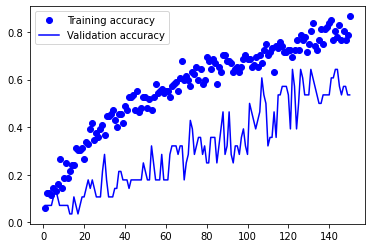

Test accuracy: 53.57%


13345

In [ ]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

test_accuracy = []
train_accuracy = []
val_accuracy = []
plotIsNeeded = True


for train_index, test_index in kf.split(data_two_crop, labels):

  data_train, data_test = data_two_crop[train_index], data_two_crop[test_index]
  label_train, label_test = labels[train_index], labels[test_index]

  print(data_test.shape)

  data_train = data_train[:, :, 0]
  data_test = data_test[:, :, 0]

  print(data_test.shape)

  model = get_one_stream_model()
  model.build(data_train[0])

  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])
  
  history = model.fit(data_train, label_train,
                    epochs = 150, 
                    validation_data = (data_test, label_test))
 
  acc = history.history['accuracy']
  epochs = range(1, len(acc) + 1)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  if plotIsNeeded:
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()
    plotIsNeeded = False
  
  train_accuracy.append(history.history['accuracy'][-1])
  val_accuracy.append(history.history['val_accuracy'][-1])
  
  print(f"Test accuracy: {round(history.history['val_accuracy'][-1] * 100, 2)}%")
  break

del model
del data_train
del data_test
gc.collect()

# Lower crop rgb

(28, 8, 2, 224, 224, 3)
(28, 8, 224, 224, 3)
Epoch 1/150
4/4 [==============================] - 8s 1s/step - loss: 3.4508 - accuracy: 0.0625 - val_loss: 2.7775 - val_accuracy: 0.1071
Epoch 2/150
4/4 [==============================] - 3s 750ms/step - loss: 3.0399 - accuracy: 0.0714 - val_loss: 2.7515 - val_accuracy: 0.1071
Epoch 3/150
4/4 [==============================] - 3s 749ms/step - loss: 2.8547 - accuracy: 0.0893 - val_loss: 2.6808 - val_accuracy: 0.1071
Epoch 4/150
4/4 [==============================] - 3s 782ms/step - loss: 2.6416 - accuracy: 0.1786 - val_loss: 2.5998 - val_accuracy: 0.1071
Epoch 5/150
4/4 [==============================] - 3s 748ms/step - loss: 2.4427 - accuracy: 0.2232 - val_loss: 2.6189 - val_accuracy: 0.1071
Epoch 6/150
4/4 [==============================] - 3s 757ms/step - loss: 2.3319 - accuracy: 0.2232 - val_loss: 2.6525 - val_accuracy: 0.1429
Epoch 7/150
4/4 [==============================] - 3s 750ms/step - loss: 2.2494 - accuracy: 0.2500 - val_loss: 2

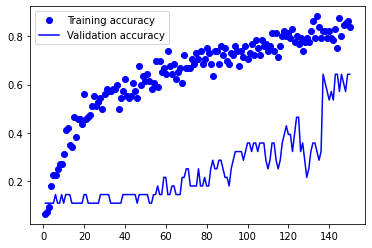

Test accuracy: 64.29%


7132

In [ ]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

test_accuracy = []
train_accuracy = []
val_accuracy = []
plotIsNeeded = True


for train_index, test_index in kf.split(data_two_crop, labels):

  data_train, data_test = data_two_crop[train_index], data_two_crop[test_index]
  label_train, label_test = labels[train_index], labels[test_index]

  print(data_test.shape)

  data_train = data_train[:, :, 1]
  data_test = data_test[:, :, 1]

  print(data_test.shape)

  model = get_one_stream_model()
  model.build(data_train[0])

  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])
  
  history = model.fit(data_train, label_train,
                    epochs = 150, 
                    validation_data = (data_test, label_test))
 
  acc = history.history['accuracy']
  epochs = range(1, len(acc) + 1)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  if plotIsNeeded:
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()
    plotIsNeeded = False
  
  train_accuracy.append(history.history['accuracy'][-1])
  val_accuracy.append(history.history['val_accuracy'][-1])
  
  print(f"Test accuracy: {round(history.history['val_accuracy'][-1] * 100, 2)}%")
  break

del model
del data_train
del data_test
gc.collect()

# 2 stream rgb

(28, 8, 2, 224, 224, 3)
(28, 8, 2, 224, 224, 3)
Epoch 1/150
4/4 [==============================] - 15s 3s/step - loss: 3.6585 - accuracy: 0.0804 - val_loss: 2.8157 - val_accuracy: 0.1429
Epoch 2/150
4/4 [==============================] - 6s 2s/step - loss: 3.0537 - accuracy: 0.1429 - val_loss: 2.6045 - val_accuracy: 0.1786
Epoch 3/150
4/4 [==============================] - 6s 2s/step - loss: 2.7996 - accuracy: 0.1250 - val_loss: 2.5615 - val_accuracy: 0.1786
Epoch 4/150
4/4 [==============================] - 6s 2s/step - loss: 2.7643 - accuracy: 0.1071 - val_loss: 2.6193 - val_accuracy: 0.1429
Epoch 5/150
4/4 [==============================] - 6s 2s/step - loss: 2.5083 - accuracy: 0.1875 - val_loss: 2.6097 - val_accuracy: 0.2143
Epoch 6/150
4/4 [==============================] - 7s 2s/step - loss: 2.3783 - accuracy: 0.2857 - val_loss: 2.5255 - val_accuracy: 0.1786
Epoch 7/150
4/4 [==============================] - 6s 1s/step - loss: 2.2974 - accuracy: 0.2232 - val_loss: 2.5516 - val_ac

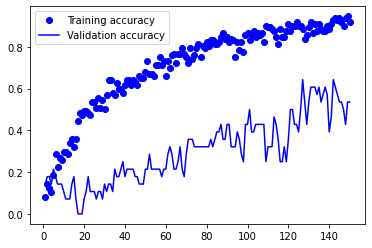

Test accuracy: 53.57%


21569

In [ ]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

test_accuracy = []
train_accuracy = []
val_accuracy = []
plotIsNeeded = True


for train_index, test_index in kf.split(data_two_crop, labels):

  data_train, data_test = data_two_crop[train_index], data_two_crop[test_index]
  label_train, label_test = labels[train_index], labels[test_index]

  print(data_test.shape)

  data_train_upper = data_train[:, :, 0]
  data_test_upper = data_test[:, :, 0]
  data_train_lower = data_train[:, :, 1]
  data_test_lower = data_test[:, :, 1]

  print(data_test.shape)

  model = get_two_stream_model()
  model.build(data_train[0])

  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])
  
  history = model.fit([data_train_upper, data_train_lower], label_train,
                    epochs = 150, 
                    validation_data = ([data_test_upper, data_test_lower], label_test))
 
  acc = history.history['accuracy']
  epochs = range(1, len(acc) + 1)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  if plotIsNeeded:
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()
    plotIsNeeded = False
  
  train_accuracy.append(history.history['accuracy'][-1])
  val_accuracy.append(history.history['val_accuracy'][-1])
  
  print(f"Test accuracy: {round(history.history['val_accuracy'][-1] * 100, 2)}%")
  break

del model
del data_train
del data_test
del data_train_upper
del data_test_upper
del data_train_lower
del data_test_lower
gc.collect()

In [ ]:
del model
del data_train
del data_test
del data_train_upper
del data_test_upper
del data_train_lower
del data_test_lower

24

# 1 crop rgb + flow (two stream)

Epoch 1/250
4/4 [==============================] - 34s 4s/step - loss: 3.2528 - accuracy: 0.0982 - val_loss: 2.7269 - val_accuracy: 0.0714
Epoch 2/250
4/4 [==============================] - 5s 1s/step - loss: 2.8979 - accuracy: 0.1071 - val_loss: 2.8243 - val_accuracy: 0.1071
Epoch 3/250
4/4 [==============================] - 5s 1s/step - loss: 2.6396 - accuracy: 0.1339 - val_loss: 2.4761 - val_accuracy: 0.1071
Epoch 4/250
4/4 [==============================] - 5s 1s/step - loss: 2.5035 - accuracy: 0.2143 - val_loss: 2.3446 - val_accuracy: 0.1786
Epoch 5/250
4/4 [==============================] - 5s 1s/step - loss: 2.3742 - accuracy: 0.2232 - val_loss: 2.3035 - val_accuracy: 0.1786
Epoch 6/250
4/4 [==============================] - 5s 1s/step - loss: 2.1332 - accuracy: 0.2946 - val_loss: 2.3074 - val_accuracy: 0.1071
Epoch 7/250
4/4 [==============================] - 5s 1s/step - loss: 2.0569 - accuracy: 0.3304 - val_loss: 2.3161 - val_accuracy: 0.1071
Epoch 8/250
4/4 [================

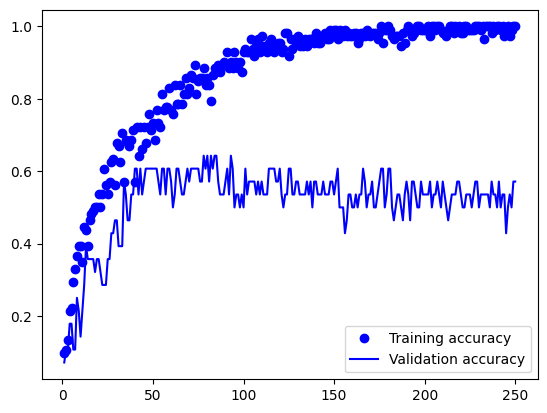

Test accuracy: 57.14%


77959

In [39]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

test_accuracy = []
train_accuracy = []
val_accuracy = []
plotIsNeeded = True

epochs = 250
batch_size = 16

for train_index, test_index in kf.split(data_one_crop, labels):

  data_train, data_test = data_one_crop[train_index], data_one_crop[test_index]
  flow_train, flow_test = flow_one_crop[train_index], flow_one_crop[test_index]
  label_train, label_test = labels[train_index], labels[test_index]

  model = get_two_stream_model()
  model.build(data_train[0])

  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])
  
  history = model.fit([data_train, flow_train], label_train,
                    epochs = epochs, 
                    validation_data = ([data_test, flow_test], label_test)
                    , batch_size = batch_size)
 
  acc = history.history['accuracy']
  epochs = range(1, len(acc) + 1)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  if plotIsNeeded:
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()
    plotIsNeeded = False
  
  train_accuracy.append(history.history['accuracy'][-1])
  val_accuracy.append(history.history['val_accuracy'][-1])
  
  print(f"Test accuracy: {round(history.history['val_accuracy'][-1] * 100, 2)}%")
  break

del model
del data_train
del data_test
del flow_train
del flow_test
gc.collect()

# 1 crop rgb + flow (one stream)

Epoch 1/250
7/7 [==============================] - 20s 874ms/step - loss: 3.2595 - accuracy: 0.1518 - val_loss: 2.7797 - val_accuracy: 0.1071
Epoch 2/250
7/7 [==============================] - 3s 503ms/step - loss: 2.8293 - accuracy: 0.1161 - val_loss: 2.5934 - val_accuracy: 0.1071
Epoch 3/250
7/7 [==============================] - 4s 554ms/step - loss: 2.4234 - accuracy: 0.1786 - val_loss: 2.4783 - val_accuracy: 0.1786
Epoch 4/250
7/7 [==============================] - 4s 530ms/step - loss: 2.3359 - accuracy: 0.2411 - val_loss: 2.4357 - val_accuracy: 0.1071
Epoch 5/250
7/7 [==============================] - 4s 554ms/step - loss: 2.3633 - accuracy: 0.2143 - val_loss: 2.3979 - val_accuracy: 0.2143
Epoch 6/250
7/7 [==============================] - 5s 707ms/step - loss: 2.2498 - accuracy: 0.2679 - val_loss: 2.3465 - val_accuracy: 0.2143
Epoch 7/250
7/7 [==============================] - 4s 511ms/step - loss: 2.2633 - accuracy: 0.1875 - val_loss: 2.2769 - val_accuracy: 0.2143
Epoch 8/250


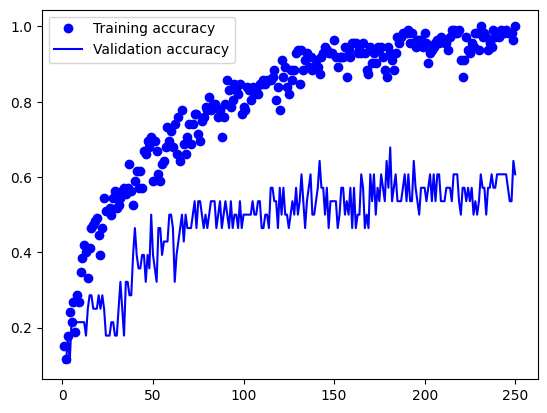

Test accuracy: 60.71%


5081

In [24]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

test_accuracy = []
train_accuracy = []
val_accuracy = []
plotIsNeeded = True

epochs = 250
batch_size = 16

for train_index, test_index in kf.split(data_one_crop, labels):

  data_train, data_test = data_one_crop[train_index], data_one_crop[test_index]
  flow_train, flow_test = flow_one_crop[train_index], flow_one_crop[test_index]
  label_train, label_test = labels[train_index], labels[test_index]

  data_train = np.concatenate([data_train, flow_train], axis = 4)
  data_test = np.concatenate([data_test, flow_test], axis = 4)

  model = get_one_stream_model_6ch()
  model.build(data_train[0])
  

  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])
  
  history = model.fit(data_train, label_train,
                    epochs = epochs, 
                    validation_data = (data_test, label_test)
                    , batch_size = batch_size)
 
  acc = history.history['accuracy']
  epochs = range(1, len(acc) + 1)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  if plotIsNeeded:
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()
    plotIsNeeded = False
  
  train_accuracy.append(history.history['accuracy'][-1])
  val_accuracy.append(history.history['val_accuracy'][-1])
  
  print(f"Test accuracy: {round(history.history['val_accuracy'][-1] * 100, 2)}%")
  break

del model
del data_train
del data_test
del flow_train
del flow_test
gc.collect()

# 2 crop rgb + flow (two stream)

Epoch 1/250
7/7 [==============================] - 29s 2s/step - loss: 3.2768 - accuracy: 0.0982 - val_loss: 3.4177 - val_accuracy: 0.0714
Epoch 2/250
7/7 [==============================] - 7s 1s/step - loss: 2.7977 - accuracy: 0.1250 - val_loss: 3.0730 - val_accuracy: 0.0714
Epoch 3/250
7/7 [==============================] - 7s 1s/step - loss: 2.5316 - accuracy: 0.2232 - val_loss: 2.9861 - val_accuracy: 0.0714
Epoch 4/250
7/7 [==============================] - 6s 953ms/step - loss: 2.4369 - accuracy: 0.2054 - val_loss: 2.9042 - val_accuracy: 0.0714
Epoch 5/250
7/7 [==============================] - 8s 1s/step - loss: 2.1612 - accuracy: 0.3036 - val_loss: 2.6682 - val_accuracy: 0.1429
Epoch 6/250
7/7 [==============================] - 9s 1s/step - loss: 2.0387 - accuracy: 0.3304 - val_loss: 2.5293 - val_accuracy: 0.1429
Epoch 7/250
7/7 [==============================] - 7s 1s/step - loss: 1.8721 - accuracy: 0.3125 - val_loss: 2.4226 - val_accuracy: 0.1429
Epoch 8/250
7/7 [=============

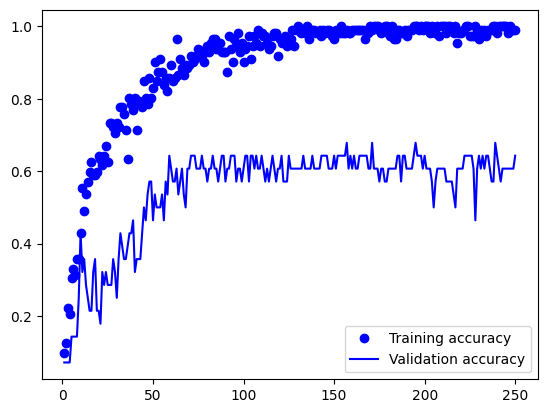

Test accuracy: 64.29%


NameError: ignored

In [24]:

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

test_accuracy = []
train_accuracy = []
val_accuracy = []
plotIsNeeded = True

epochs = 250
batch_size = 16

del model
del data_one_crop
del flow_one_crop
gc.collect()

for train_index, test_index in kf.split(data_two_crop, labels):

  data_upper = data_two_crop[:, :, 0]
  flow_upper = flow_two_crop[:, :, 0]
  data_lower = data_two_crop[:, :, 1]
  flow_lower = flow_two_crop[:, :, 1]

  del data_two_crop
  del flow_two_crop
  gc.collect()

  fusion_u = np.concatenate([data_upper, flow_upper], axis = 4)
  fusion_l = np.concatenate([data_lower, flow_lower], axis = 4)

  del data_upper
  del flow_upper
  del data_lower
  del flow_lower
  gc.collect()

  fusion_u_train, fusion_u_test = fusion_u[train_index], fusion_u[test_index]
  fusion_l_train, fusion_l_test = fusion_l[train_index], fusion_l[test_index]
  label_train, label_test = labels[train_index], labels[test_index]

  del fusion_u
  del fusion_l
  gc.collect()


  model = get_two_stream_model_6ch()
  model.build(fusion_u_train[0])
  
  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])
  
  history = model.fit([fusion_u_train, fusion_l_train], label_train,
                    epochs = epochs, 
                    validation_data = ([fusion_u_test, fusion_l_test], label_test)
                    , batch_size = batch_size)
 
  acc = history.history['accuracy']
  epochs = range(1, len(acc) + 1)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  if plotIsNeeded:
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()
    plotIsNeeded = False
  
  train_accuracy.append(history.history['accuracy'][-1])
  val_accuracy.append(history.history['val_accuracy'][-1])
  
  print(f"Test accuracy: {round(history.history['val_accuracy'][-1] * 100, 2)}%")
  break

del model
del data_train
del data_test
del flow_train
del flow_test
gc.collect()

# 2 crop rgb + flow (four stream)

In [14]:
del data_one_crop
del flow_one_crop
gc.collect()

63

Epoch 1/250
7/7 [==============================] - 40s 3s/step - loss: 4.1016 - accuracy: 0.1071 - val_loss: 2.8674 - val_accuracy: 0.0714
Epoch 2/250
7/7 [==============================] - 10s 2s/step - loss: 3.5700 - accuracy: 0.0982 - val_loss: 2.7879 - val_accuracy: 0.2857
Epoch 3/250
7/7 [==============================] - 10s 1s/step - loss: 3.2714 - accuracy: 0.1339 - val_loss: 2.6370 - val_accuracy: 0.1429
Epoch 4/250
7/7 [==============================] - 10s 2s/step - loss: 2.9373 - accuracy: 0.2232 - val_loss: 2.6826 - val_accuracy: 0.1786
Epoch 5/250
7/7 [==============================] - 11s 2s/step - loss: 2.6741 - accuracy: 0.2054 - val_loss: 2.8011 - val_accuracy: 0.1429
Epoch 6/250
7/7 [==============================] - 10s 2s/step - loss: 2.3323 - accuracy: 0.2143 - val_loss: 2.7110 - val_accuracy: 0.1429
Epoch 7/250
7/7 [==============================] - 10s 1s/step - loss: 2.3387 - accuracy: 0.2768 - val_loss: 2.5163 - val_accuracy: 0.1071
Epoch 8/250
7/7 [==========

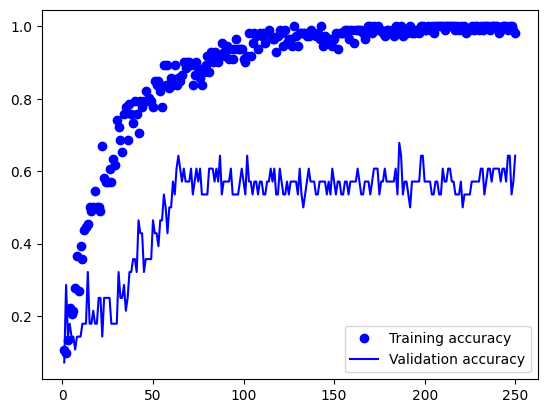

Test accuracy: 64.29%


NameError: ignored

In [15]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

test_accuracy = []
train_accuracy = []
val_accuracy = []
plotIsNeeded = True

epochs = 250
batch_size = 16

#del model
#del data_one_crop
#del flow_one_crop
gc.collect()

for train_index, test_index in kf.split(data_two_crop, labels):

  data_upper = data_two_crop[:, :, 0]
  flow_upper = flow_two_crop[:, :, 0]
  data_lower = data_two_crop[:, :, 1]
  flow_lower = flow_two_crop[:, :, 1]

  del data_two_crop
  del flow_two_crop
  gc.collect()

  data_upper_train, data_upper_test = data_upper[train_index], data_upper[test_index]
  flow_upper_train, flow_upper_test = flow_upper[train_index], flow_upper[test_index]
  data_lower_train, data_lower_test = data_lower[train_index], data_lower[test_index]
  flow_lower_train, flow_lower_test = flow_lower[train_index], flow_lower[test_index]
  label_train, label_test = labels[train_index], labels[test_index]

  del data_upper
  del flow_upper
  del data_lower
  del flow_lower
  gc.collect()

  model = get_four_stream_model()
  model.build([data_upper_train, flow_upper_train, data_lower_train, flow_lower_train])
  
  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])
  
  history = model.fit([data_upper_train, flow_upper_train, data_lower_train, flow_lower_train], label_train,
                    epochs = epochs, 
                    validation_data = ([data_upper_test, flow_upper_test, data_lower_test, flow_lower_test], label_test)
                    , batch_size = batch_size)
 
  acc = history.history['accuracy']
  epochs = range(1, len(acc) + 1)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  if plotIsNeeded:
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()
    plotIsNeeded = False
  
  train_accuracy.append(history.history['accuracy'][-1])
  val_accuracy.append(history.history['val_accuracy'][-1])
  
  print(f"Test accuracy: {round(history.history['val_accuracy'][-1] * 100, 2)}%")
  break

del model
del data_train
del data_test
del flow_train
del flow_test
gc.collect()

# upper crop rgb + flow (two stream)

Epoch 1/250
7/7 [==============================] - 26s 1s/step - loss: 3.5279 - accuracy: 0.0446 - val_loss: 2.8397 - val_accuracy: 0.0714
Epoch 2/250
7/7 [==============================] - 6s 817ms/step - loss: 2.9637 - accuracy: 0.1429 - val_loss: 2.7993 - val_accuracy: 0.1429
Epoch 3/250
7/7 [==============================] - 5s 732ms/step - loss: 2.7475 - accuracy: 0.1518 - val_loss: 2.7140 - val_accuracy: 0.1429
Epoch 4/250
7/7 [==============================] - 5s 777ms/step - loss: 2.5084 - accuracy: 0.1429 - val_loss: 2.6349 - val_accuracy: 0.1071
Epoch 5/250
7/7 [==============================] - 5s 756ms/step - loss: 2.4874 - accuracy: 0.1518 - val_loss: 2.5642 - val_accuracy: 0.1429
Epoch 6/250
7/7 [==============================] - 5s 724ms/step - loss: 2.4000 - accuracy: 0.1786 - val_loss: 2.5360 - val_accuracy: 0.1429
Epoch 7/250
7/7 [==============================] - 5s 800ms/step - loss: 2.2500 - accuracy: 0.2321 - val_loss: 2.5900 - val_accuracy: 0.1786
Epoch 8/250
7/7

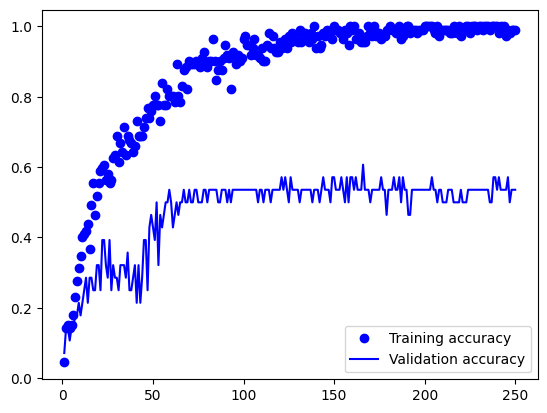

Test accuracy: 53.57%


5273

In [9]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

test_accuracy = []
train_accuracy = []
val_accuracy = []
plotIsNeeded = True

epochs = 250
batch_size = 16

for train_index, test_index in kf.split(data_two_crop, labels):

  data_upper = data_two_crop[:, :, 0]
  flow_upper = flow_two_crop[:, :, 0]

  data_train, data_test = data_upper[train_index], data_upper[test_index]
  flow_train, flow_test = flow_upper[train_index], flow_upper[test_index]
  label_train, label_test = labels[train_index], labels[test_index]

  model = get_two_stream_model()
  model.build(data_train[0])

  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])
  
  history = model.fit([data_train, flow_train], label_train,
                    epochs = epochs, 
                    validation_data = ([data_test, flow_test], label_test)
                    , batch_size = batch_size)
  
 
  acc = history.history['accuracy']
  epochs = range(1, len(acc) + 1)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  if plotIsNeeded:
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()
    plotIsNeeded = False
  
  train_accuracy.append(history.history['accuracy'][-1])
  val_accuracy.append(history.history['val_accuracy'][-1])
  
  print(f"Test accuracy: {round(history.history['val_accuracy'][-1] * 100, 2)}%")
  break

del model
del data_train
del data_test
del flow_train
del flow_test
gc.collect()

# upper crop rgb + flow (one stream)

Epoch 1/250
7/7 [==============================] - 25s 1s/step - loss: 3.4570 - accuracy: 0.0714 - val_loss: 2.7476 - val_accuracy: 0.0714
Epoch 2/250
7/7 [==============================] - 3s 488ms/step - loss: 2.7309 - accuracy: 0.1071 - val_loss: 2.8282 - val_accuracy: 0.0357
Epoch 3/250
7/7 [==============================] - 3s 500ms/step - loss: 2.5275 - accuracy: 0.1518 - val_loss: 2.8157 - val_accuracy: 0.1429
Epoch 4/250
7/7 [==============================] - 4s 522ms/step - loss: 2.5594 - accuracy: 0.1875 - val_loss: 2.7757 - val_accuracy: 0.1071
Epoch 5/250
7/7 [==============================] - 3s 483ms/step - loss: 2.6071 - accuracy: 0.1339 - val_loss: 2.7624 - val_accuracy: 0.1071
Epoch 6/250
7/7 [==============================] - 3s 489ms/step - loss: 2.3118 - accuracy: 0.2321 - val_loss: 2.7343 - val_accuracy: 0.2143
Epoch 7/250
7/7 [==============================] - 3s 459ms/step - loss: 2.2419 - accuracy: 0.2411 - val_loss: 2.7466 - val_accuracy: 0.1429
Epoch 8/250
7/7

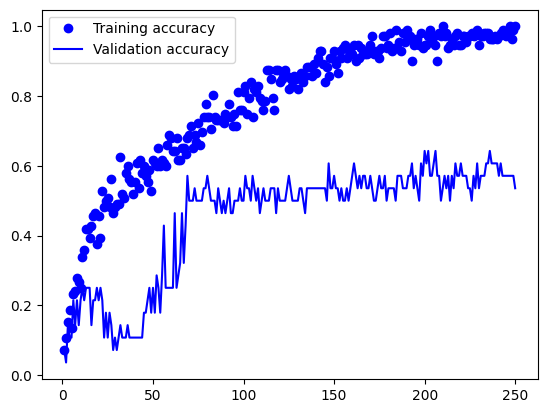

Test accuracy: 53.57%


13408

In [12]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

test_accuracy = []
train_accuracy = []
val_accuracy = []
plotIsNeeded = True

epochs = 250
batch_size = 16

for train_index, test_index in kf.split(data_two_crop, labels):

  data_upper = data_two_crop[:, :, 0]
  flow_upper = flow_two_crop[:, :, 0]

  data_train, data_test = data_upper[train_index], data_upper[test_index]
  flow_train, flow_test = flow_upper[train_index], flow_upper[test_index]
  label_train, label_test = labels[train_index], labels[test_index]

  data_train = np.concatenate([data_train, flow_train], axis = 4)
  data_test = np.concatenate([data_test, flow_test], axis = 4)

  model = get_one_stream_model_6ch()
  model.build(data_train[0])
  

  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])
  
  history = model.fit(data_train, label_train,
                    epochs = epochs, 
                    validation_data = (data_test, label_test)
                    , batch_size = batch_size)
 
  acc = history.history['accuracy']
  epochs = range(1, len(acc) + 1)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']
  if plotIsNeeded:
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()
    plotIsNeeded = False
  
  train_accuracy.append(history.history['accuracy'][-1])
  val_accuracy.append(history.history['val_accuracy'][-1])
  
  print(f"Test accuracy: {round(history.history['val_accuracy'][-1] * 100, 2)}%")
  break

del model
del data_train
del data_test
del flow_train
del flow_test
gc.collect()